In [1]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from ekf_vindy.plotting import plotter
from ekf_vindy.ekf.utils import add_noise_with_snr
from ekf_vindy.ekf.filters.config import DynamicsConfig
from ekf_vindy.ekf.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

/home/carlos/.cache/pypoetry/virtualenvs/vindy-MoRRIXoN-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.


# EKF-SINDy with Duffing oscillator (FAILED)

We examine a simulation with a Duffing oscillator, and we want to inform the filter about energy conservation. We consider:
-  We learn a system where energy is conserved, and energy gradually is lost via a damping, however, we do not know the actual damping term. 

## Duffing oscillator

The undamped Duffing oscillator is the following

$$
\ddot{x}+\alpha x + \beta x^3 = 0
$$

Energy is conserved (a physical constraint in an isolated system). We consider the damped oscillator:

$$
\ddot{x}+\delta \dot{x}+\alpha x+ \beta x^3 + \delta \dot{x}^3= 0, \,\,\delta > 0
$$

We consider the first-order version of the damped oscillator

$$
\begin{aligned}
\dot{x}_0 &= x_1,\\
\dot{x}_1 &= - \alpha x_0-  \beta x_0^3 - \delta x_1 - \delta x_1^3
\end{aligned}
$$

In [2]:
def duffing_oscillator(x, t, params, t_conservation):
    """
    Duffing oscillator ODE
    """
    if t >= t_conservation:
        delta_1 = 0.0
        delta_2 = 0.0
    else:
        delta_1 = params['delta_1']
        delta_2 = params['delta_2']

    dxdt = x[1]
    dvdt = - params['alpha'] * x[0] - params['beta'] * x[0] ** 3 - delta_1 * x[1] - delta_2 * x[1] ** 3 
    
    return [dxdt, dvdt]

The total energy of this system is given by the Hamiltonian (potential and kinetic energy). 

$$
E(x(t), \dot{x}(t)) = \frac{1}{2}\dot{x}^2(t) +\frac{1}{2}\alpha x^2(t) +\frac{1}{4}\beta x^4(t)
$$

However, we are interested in constraining on the **loss** of such energy. We see how the energy varies (we denote it with $E$).

$$
\frac{\textrm{d}E}{\textrm{d}t} = -\delta\dot{x}^2-\delta \dot{x}^4.
$$

This indicates how the energy changes assuming we know the damping term $\delta$. At each step, we will constrain on such loss (by considering our current estimate of the damping term). Given small enough time steps, a local approximation of the integral should work. 

$$
\Delta E(t_n) = \int^{t_n}_{t_{n-1}} -\delta\dot{x}^2-\delta \dot{x}^4 \, \mathrm{d}t.
$$

We use any integration scheme, preferably an RK4 step. However, for now, consider a simple Euler step, so the predicted energy difference under the current estimate is

$$
    \Delta E(t_n) \approx \Delta \bar{E}(t_n)=-\delta [\dot{x}(t_n)^2 + \dot{x}(t_n)^4]\Delta t
$$

For the general case, with two different damping coefficients, we would have:

$$
    \Delta E(t_n) \approx \Delta \bar{E}(t_n)=-[\delta_1 \dot{x}(t_n)^2 + \delta_2 \dot{x}(t_n)^4]\Delta t
$$

In a Kalman filter we want a residual as our innovation. Unfortunately, here we don't really know what to compare against, so we will have to rely on an estimate... for example, we could compare our prediction of energy loss against the estimated energy loss between measurements. 

$$
\Delta \tilde{E}(t_n) = \tilde{E}(t_n) - \tilde{E}(t_{n-1}).
$$

In the noiseless case this should be very warranted, since you are comparing against the **exact** energy loss. We would essentially be comparing these differences (the estimate from measurements, and the projected one from our current model). We would be enforcing $\Delta \bar{E}(t_n) = \Delta \tilde{E}(t_n)$, equivalent to asking 

$$
g(x(t_n), \dot{x}(t_n), \delta(t_n)) = \Delta \bar{E}(t_n) - \Delta \tilde{E}(t_n) = 0
$$

The Jacobian would only involve the $ \Delta \bar{E}(t_n)$. 

Now the functions for the Jacobian of the energy loss and the energy itself

Train on undamped trajectories.

(x0)' = 0.995 x1
(x1)' = -1.074 x0 + -0.953 x0^3


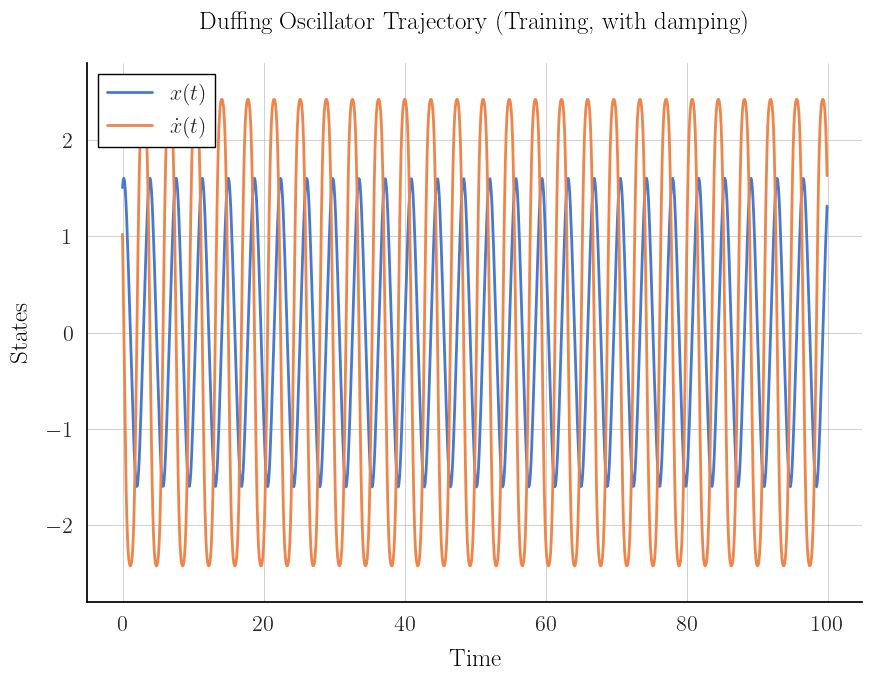

In [4]:
params = {
    'alpha': 1,   # Linear stiffness
    'beta': 1,     # Nonlinear stiffness
    'delta_1': 0.5,  # Linear damping 
    'delta_2': 0.5,  # Cubic damping 
}

# Generate training data (around [1.5, 0] initial condition)
t_conservation = 0.0 # energy is depleted by then

n_train = 20
std = 0.01
mean_ic = np.array([1.5, 1.0])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 100, 0.1)
x_train = []


for i in range(n_train):
    sol = odeint(duffing_oscillator, x_0[i, :], time_instances, args=(params, t_conservation))
    x_train.append(sol)

x_train = np.array(x_train)
x_train = [noisy_traj for noisy_traj in add_noise_with_snr(x_train, snr=500)]

model = ps.SINDy(feature_names=['x0', 'x1'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(x_train, t=0.1, multiple_trajectories=True)
model.print()

# plot one trajectory from x_train
fig, ax = plotter.plot_trajectory(x_train[0], time_instances, title='Duffing Oscillator Trajectory (Training, with damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.8, 2.8), x_tick_skip=20)
# plt.savefig("/home/ridley/Downloads/duffing_training.svg", bbox_inches='tight')
plt.show()

Now let's produce a trajectory with non-zero damping coefficients.

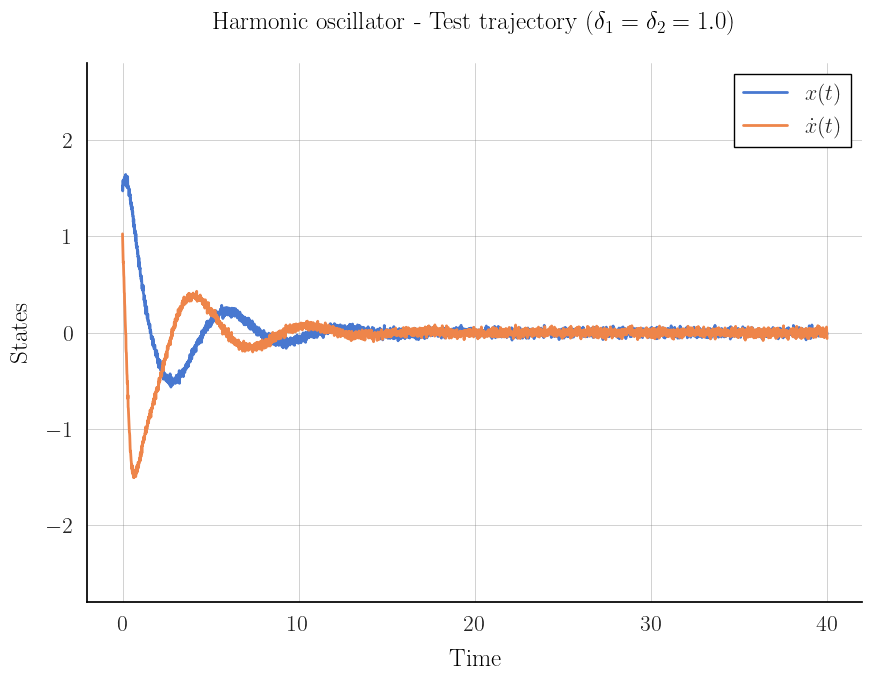

library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']


In [5]:
from ekf_vindy.ekf.filters.constraints import Constraint

t_conservation = 400.0
time_instances = np.arange(0, 40, 0.01)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
x_test_noiseless = x_test.copy()
x_test = add_noise_with_snr(x_test, snr=20)

fig, ax = plotter.plot_trajectory(x_test, time_instances, x_tick_skip=10, title='Harmonic oscillator - Test trajectory ($\delta_1 = \delta_2 = 1.0$)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"],
                                   ylim=(-2.8, 2.8))
# plt.savefig("/home/ridley/Downloads/duffing_test.svg", bbox_inches='tight')
plt.show()

print(f'library_terms: {model.get_feature_names()}')

library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']


Processing: 100%|██████████| 3999/3999 [00:01<00:00, 3378.39it/s]


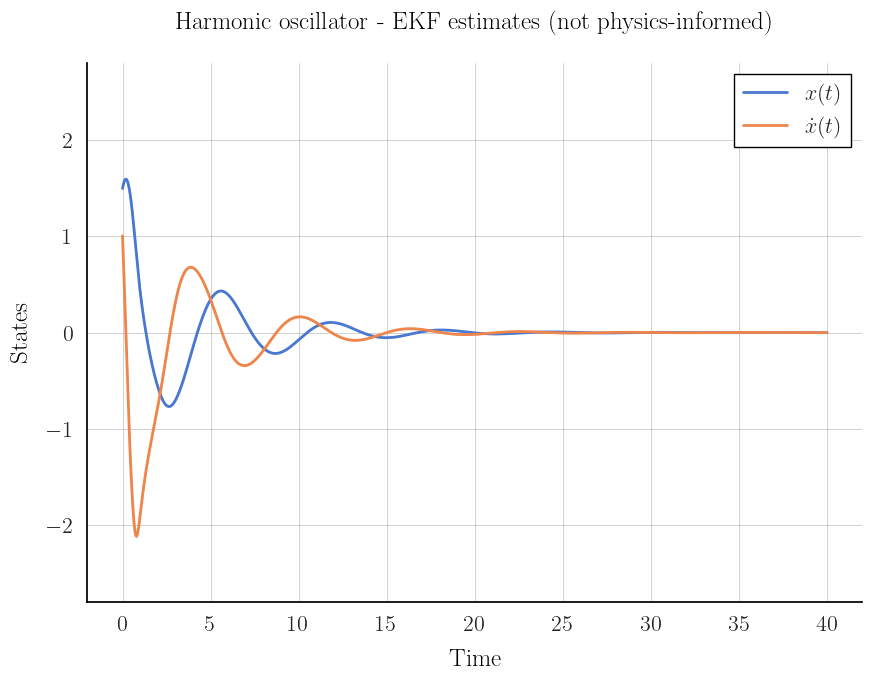

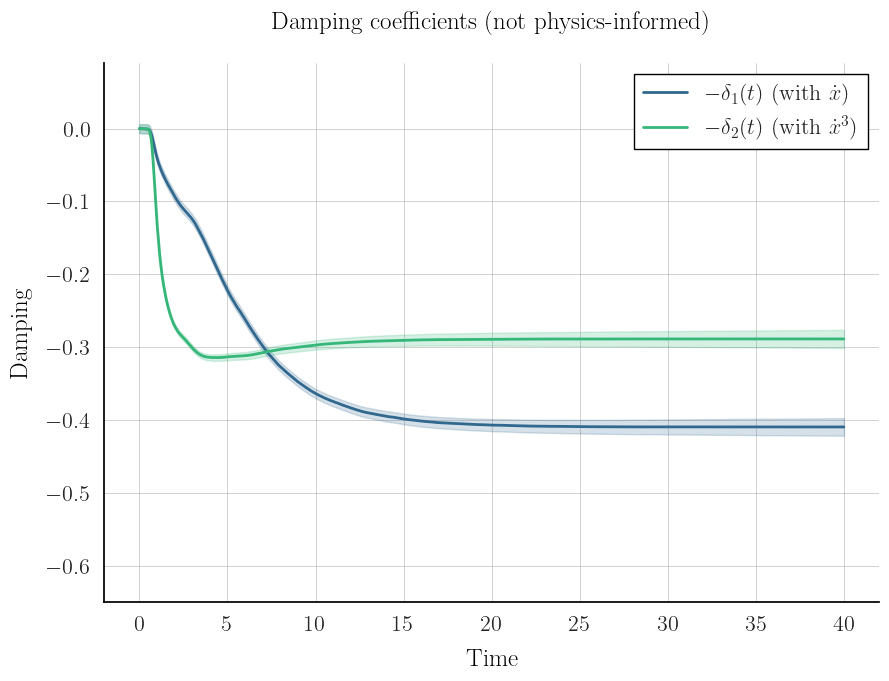

In [6]:
# you gotta track state and coeffs of x1 and x^3. indices are 2, 9

# EKF configuration
p0 = np.diag([1e-8, 1e-8, 1e-5, 1e-5]) # initial state covariance
q = np.diag([1e-8, 1e-8, 1e-6, 1e-6]) # process noise covariance
r = np.diag([4e-3, 4e-3])

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names

print(f'library_terms: {library_terms}')
tracked_terms = [[],
               [2, 9]]
alpha, beta = -coeffs[1][1], -coeffs[1][6]


x0 = x_0_test[0, :]
config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
filter = EKF(x0, p0, config=config, integration_rule='RK4')

dts = np.diff(time_instances)
observations = x_test[1:, :]
filter.run_filter(dts, observations)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]

fig, x_cal = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=5, title='Harmonic oscillator - EKF estimates (not physics-informed)', xlabel='Time', ylabel='States', 
                                     state_names=["$x(t)$", "$\dot{x}(t)$"],
                                     ylim=(-2.8, 2.8))
# plt.savefig("/home/ridley/Downloads/duffing_states_no.svg", bbox_inches='tight')
plt.show()

damping_term = filter.states.xcal_states[:, 2:]
damping_sdev = filter.states.sdev_states[:, 2:]

fig, x_cal = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=5, title="Damping coefficients (not physics-informed)", xlabel='Time', ylabel='Damping',
                                 state_names=["$-\delta_1 (t)$ (with $\dot{x}$)", "$-\delta_2 (t)$ (with $\dot{x}^3$)"],
                                 ylim=(-0.65, 0.09), palette='viridis')
# plt.savefig("/home/ridley/Downloads/duffing_coeffs_no.svg", bbox_inches='tight')
plt.show()

Now let's enforce the constraint. Now that I think of it, it's not really a pseudo-observation, since I am actually using a real estimate from data, it's more a physics-informed filter in general. 

In other case it was a pseudo-observation, since I was exclusively conditioning on some transformation of my current estimate. 

Processing: 100%|██████████| 3999/3999 [00:02<00:00, 1506.62it/s]


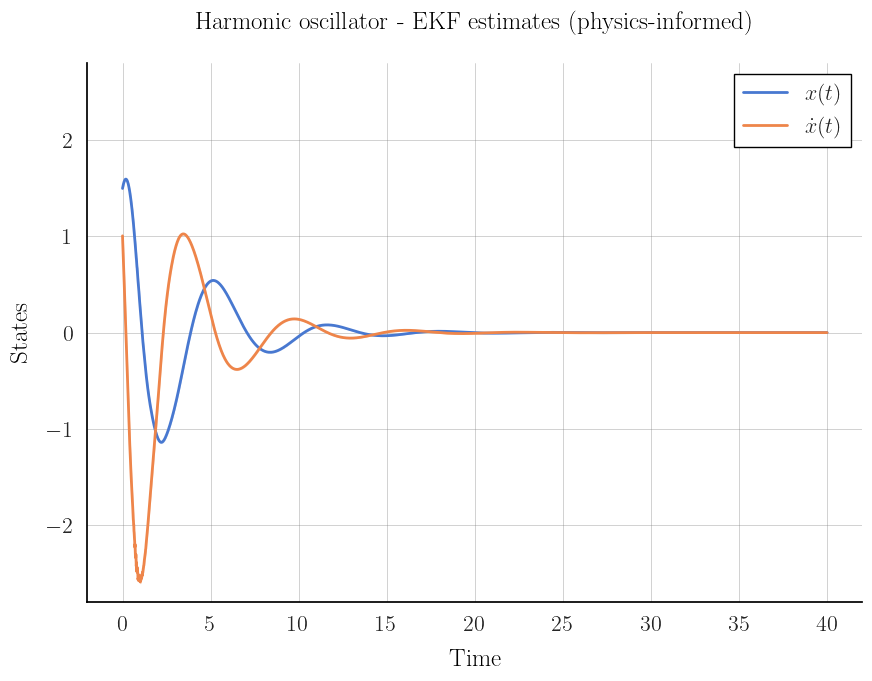

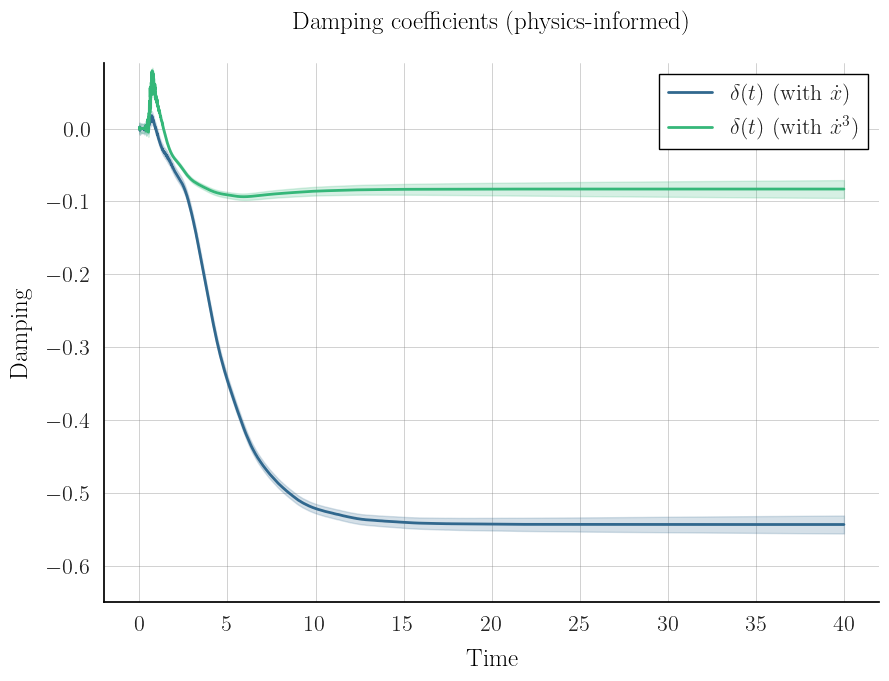

In [8]:
from ekf_vindy.plotting import plotter
from ekf_vindy.ekf.filters.ekf import EKF
from ekf_vindy.ekf.filters.constraints import LossDuffingCubic

constr_cov = np.diag([7e-6])
full_dimension = 2 + filter.n_tracked_terms

constraint = LossDuffingCubic(alpha, beta, constr_cov, full_dimension)

filter = EKF(x0, p0, config=config, integration_rule='RK4')
filter.run_filter(dts, observations, constraint)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]
fig, x_cal = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=5, title='Harmonic oscillator - EKF estimates (physics-informed)', xlabel='Time', ylabel='States', 
                                     state_names=["$x(t)$", "$\dot{x}(t)$"],
                                     ylim=(-2.8, 2.8))
# plt.savefig("/home/ridley/Downloads/duffing_states_physics.svg", bbox_inches='tight')
plt.show()

damping_term = filter.states.xcal_states[:, 2:]
damping_sdev = filter.states.sdev_states[:, 2:]

fig, x_cal = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=5, title="Damping coefficients (physics-informed)", xlabel='Time', ylabel='Damping',
                                 state_names=["$\delta (t)$ (with $\dot{x}$)", "$\delta (t)$ (with $\dot{x}^3$)"],
                                 ylim=(-0.65, 0.09), palette='viridis')
# plt.savefig("/home/ridley/Downloads/duffing_coeffs_physics.svg", bbox_inches='tight')
plt.show()
